In [95]:
"""
Zachary Katz
zachary_katz@mines.edu
26 January 2026

Load and plot seismic data hosted on IRIS using Obspy's FDSN client.
This example loads the z-component of one station for a specific event and
the station's associated metadata, but other components/wildcards are possible.

Antarctic permanent stations near Whillans Ice Plain:
VNDA [Vanda Dry Valley], https://ds.iris.edu/mda/GT/VNDA/
    Multiple instruments are deployed at VNDA. 
    The KS54000 broadband seismometer has location code 00 and channels BHE, BHN, BHZ.
QSPA [South Pole], https://ds.iris.edu/mda/IU/QSPA/
    Multiple instruments are deployed at QSPA.
    The KS54000 broadband seismometer has location code 00 and channels BH1, BH2, BHZ.

See Pratt et al., 2014 for background on Whillans seismicity as detected by 
permanent stations: https://doi.org/10.1002/2013JF002842

Example usage of FDSN client from Obspy documentation:
https://docs.obspy.org/packages/obspy.clients.fdsn.html
"""

# Imports
import os
import numpy as np
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt

################################
#### User defined variables ####

# Network and station parameters are pulled from the IRIS links for each station.
data_center = "IRIS"
network = "GT"
station = "VNDA"
location = "00"
channel = "BHZ" # Can get multiple channels with wildcards, e.g., 'BH?'

# Start and end times of event
# Can be obtained from .evt files in events.zip at https://zenodo.org/records/17797751
# In this case, I chose the event shown in Pratt et al., 2014 Figure 4d to check my results. 
start_time = obspy.UTCDateTime("2011-12-19T12:20:00.000")
end_time = obspy.UTCDateTime("2011-12-19T13:10:00.000")

# Output storage
outdir = './_Output'
################################

Envelope Area, 9.529258613902596e-06


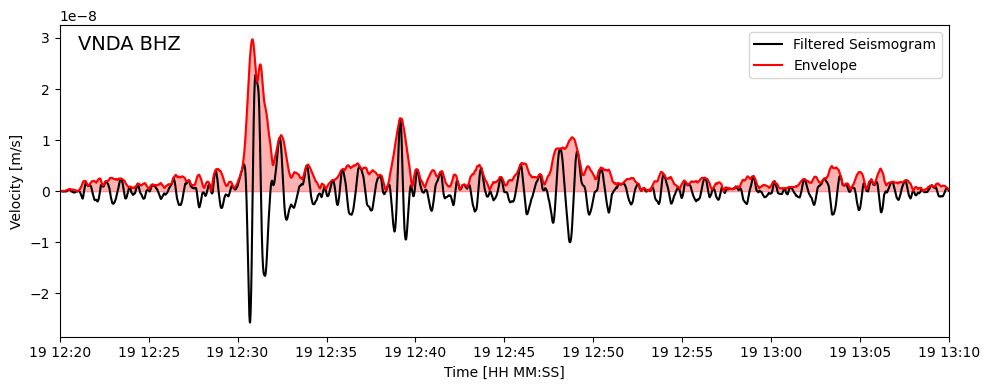

In [96]:
# Set up downloader and file system
client = Client(data_center)
os.makedirs(outdir, exist_ok=True)

# Download single trace and response file
st = client.get_waveforms(network, station, location, channel, start_time, end_time)
inv = client.get_stations(start_time, end_time, network=network, station=station,location=location, level="response")

# Detrend and remove instrument response (counts --> velocity)
# Adjust pre filter, demeaning, and detrending to shape waveform
st.remove_response(inventory=inv, output="VEL",pre_filt=(0.005, 0.015, 20, 30)) 
st.filter("bandpass", freqmin=1/100, freqmax=1/30) # Filter to see events

# Calculate variable of interest
# In this case, calculate the signal envelope (Hilbert transform) and find the area.
envelope = obspy.signal.filter.envelope(st[0].data)
area = np.trapz(envelope, dx=st[0].stats.delta)
print(f"Envelope Area, {area}")

# Plot to compare to Pratt et al., 2014 Figure 4d
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(st[0].times("matplotlib"), st[0].data, 'k',label='Filtered Seismogram')
plt.plot(st[0].times("matplotlib"), envelope, 'r', label='Envelope')
plt.fill_between(st[0].times("matplotlib"), 0, envelope, color='red', alpha=0.3)
ax.xaxis_date()
ax.set_ylabel("Velocity [m/s]")
ax.set_xlabel("Time [HH MM:SS]")
ax.text(0.02, 0.92, f'{station} {channel}', transform=ax.transAxes, fontsize=14)
ax.set_xlim(st[0].times("matplotlib")[0], st[0].times("matplotlib")[-1])
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(outdir, f"{station}_{channel}.png"), dpi=300)